In [1]:
import pyomo.environ as pyo

In [2]:


class BenchmarkOpti:

    def __init__(self, params_dict):
        
        #
        # Define the parameters given in dictionary
        #

        self.battery_capacities = params_dict['battery_capacities']
        self.battery_charging_power = params_dict['battery_charging_power']
        self.battery_discharging_power = params_dict['battery_discharging_power']
        self.grid_max_power = params_dict['grid_max_power']
        self.inital_soe = params_dict['inital_soe']
        self.feed_in_tariff = params_dict['feed_in_tariff']
        self.time = params_dict['time']
        self.eco_factor = params_dict['eco_factor']

        #
        # Prices in lenght of time
        #

        self.cost_buy = params_dict['cost_buy']
        self.profit_sell = params_dict['profit_sell']

        #
        # Netload in lenght of time
        #

        self.netload = params_dict['netload']

        #
        # Emission costs in lenght of time
        #

        self.emissions = params_dict['emissions']

        #
        # Model definition
        #
        
        self.model = pyo.AbstractModel()

        self.define_model(self.model)



    #
    # Define the model
    #

    def define_model(self, model):
        
        model.time = pyo.RangeSet(1,self.time)
        
        #
        # Decision Variables
        #
    
        model.energy_sell = pyo.Var(model.time,domain=pyo.NonNegativeReals)

        model.energy_buy = pyo.Var(model.time,domain=pyo.NonNegativeReals)

        model.sell_buy = pyo.Var(model.time,domain=pyo.Binary)

        #
        # battery action
        #

        model.battery_action = pyo.Var(model.time,domain=pyo.NonNegativeReals)
        
        model.soe = pyo.Var(model.time, domain=pyo.NonNegativeReals)

        #
        # Time dependent costs
        #

        model.cost_buy = pyo.Param(model.time,domain=pyo.NonNegativeReals)
        model.profit_sell = pyo.Param(model.time,domain=pyo.NonNegativeReals)

        #
        # Time dependent netload
        #

        model.netload = pyo.Param(model.time,domain=pyo.Reals)
        
        #
        # time dependent emissions
        #

        model.emissions = pyo.Param(model.time,domain=pyo.Reals)

        #
        # activate the constraints
        #

        model.constraint_soe = pyo.Constraint(model.time,rule=self.constraint_rule_soe)
        model.constraint_soe_initial = pyo.Constraint(rule=self.constraint_rule_soe_initial)
        model.constraint_energy_buy_and_sell = pyo.Constraint(model.time,rule=self.constraint_energy_buy_and_sell)
        model.constraint_energy_sell = pyo.Constraint(model.time,rule=self.constraint_energy_sell)
        model.constraint_energy_buy = pyo.Constraint(model.time,rule=self.constraint_energy_buy)
        model.constraint_max_battery_action = pyo.Constraint(model.time,rule=self.constraint_max_battery_action)
        model.constraint_min_battery_action = pyo.Constraint(model.time,rule=self.constraint_min_battery_action)
        model.constraint_soe = pyo.Constraint(model.time,rule=self.constraint_soe)

        


    #
    # Objective Rule
    #

    def objective_rule(self,model):

        profit = sum(model.ernergy_sell[t] * model.profit_sell[t] for t in model.time)
        cost = sum(model.ernergy_buy[t] * model.cost_buy[t] for t in model.time)
        emission_cost = sum(model.energy_buy[t] * model.emissions[t]for t in model.time)
        
        # obj = (1 - eco_factor) * (profit-cost) - eco_factor * emissions

        return (1 - self.eco_factor) * (profit - cost) - self.eco_factor * emission_cost
    
    #
    # Constraints
    #

    def constraint_rule_soe(self,model,t):
        return model.soe[t] <= self.battery_capacities
    
    def constraint_rule_soe_initial(self,model):
        return model.soe[1] == self.inital_soe
    
    def constraint_energy_buy_and_sell(self,model,t):
        return 0 == model.energy_buy[t] * model.energy_sell[t]
    
    def constraint_energy_sell(self,model,t):
        return model.energy_sell[t] == (model.netload[t] - model.battery_action[t]) * model.sell_buy[t]

    def constraint_energy_buy(self,model,t):
        return model.energy_buy[t] == (model.netload[t] + model.battery_action[t]) * (1 - model.sell_buy[t])
    
    def constraint_max_battery_action(self,model,t):
        return model.battery_action[t] <= self.battery_charging_power
    
    def constraint_min_battery_action(self,model,t):
        return model.battery_action[t] >= self.battery_discharging_power

    def constraint_soe(self,model,t):
        return model.battery_action[t] == model.soe[t-1] - model.soe[t]

    






In [3]:
# Create dummy data

params_dict = {
    'battery_capacities': 100,
    'battery_charging_power': 10,
    'battery_discharging_power': 10,
    'grid_max_power': 10,
    'inital_soe': 0,
    'feed_in_tariff': 0.1,
    'time': 24,
    'eco_factor': 0.5,
    'cost_buy': [0.1 for i in range(24)],
    'profit_sell': [0.1 for i in range(24)],
    'netload': [0.1 for i in range(24)],
    'emissions': [0.1 for i in range(24)]
}

# Create the model

benchmark = BenchmarkOpti(params_dict)

# Create the instance

instance = benchmark.model.create_instance()

# Create the solver

solver = pyo.SolverFactory('glpk')

# Solve the model

results = solver.solve(instance)



(type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown
with a new Component (type=<class
'pyomo.core.base.constraint.IndexedConstraint'>). This is usually indicative
of a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
ERROR: Rule failed when generating expression for Constraint
constraint_energy_sell with index 1: ValueError: Error retrieving immutable
Param value (netload[1]):
            The Param value is undefined and no default value is specified.
ERROR: Constructing component 'constraint_energy_sell' from data=None failed:
ValueError: Error retrieving immutable Param value (netload[1]):
        The Param value is undefined and no default value is specified.


ValueError: Error retrieving immutable Param value (netload[1]):
	The Param value is undefined and no default value is specified.

In [4]:
import pyomo.environ as pyo

class BenchmarkOpti:

    def __init__(self, params_dict):
        #
        # Define the parameters given in dictionary
        #
        self.battery_capacities = params_dict['battery_capacities']
        self.battery_charging_power = params_dict['battery_charging_power']
        self.battery_discharging_power = params_dict['battery_discharging_power']
        self.grid_max_power = params_dict['grid_max_power']
        self.inital_soe = params_dict['inital_soe']
        self.feed_in_tariff = params_dict['feed_in_tariff']
        self.time = params_dict['time']
        self.eco_factor = params_dict['eco_factor']

        #
        # Prices in length of time
        #
        self.cost_buy = params_dict['cost_buy']
        self.profit_sell = params_dict['profit_sell']

        #
        # Netload in length of time
        #
        self.netload = params_dict['netload']

        #
        # Emission costs in length of time
        #
        self.emissions = params_dict['emissions']

        #
        # Model definition
        #
        self.model = pyo.AbstractModel()
        self.define_model(self.model)

    #
    # Define the model
    #
    def define_model(self, model):
        model.time = pyo.RangeSet(1, self.time)

        #
        # Decision Variables
        #
        model.energy_sell = pyo.Var(model.time, domain=pyo.NonNegativeReals)
        model.energy_buy = pyo.Var(model.time, domain=pyo.NonNegativeReals)
        model.sell_buy = pyo.Var(model.time, domain=pyo.Binary)

        #
        # Battery action
        #
        model.battery_action = pyo.Var(model.time, domain=pyo.NonNegativeReals)
        model.soe = pyo.Var(model.time, domain=pyo.NonNegativeReals)

        #
        # Time dependent costs
        #
        model.cost_buy = pyo.Param(model.time, initialize=self.cost_buy, domain=pyo.NonNegativeReals)
        model.profit_sell = pyo.Param(model.time, initialize=self.profit_sell, domain=pyo.NonNegativeReals)

        #
        # Time dependent netload
        #
        model.netload = pyo.Param(model.time, initialize=self.netload, domain=pyo.Reals)

        #
        # Time dependent emissions
        #
        model.emissions = pyo.Param(model.time, initialize=self.emissions, domain=pyo.Reals)

        #
        # Activate the constraints
        #
        model.constraint_soe = pyo.Constraint(model.time, rule=self.constraint_rule_soe)
        model.constraint_soe_initial = pyo.Constraint(rule=self.constraint_rule_soe_initial)
        model.constraint_energy_buy_and_sell = pyo.Constraint(model.time, rule=self.constraint_energy_buy_and_sell)
        model.constraint_energy_sell = pyo.Constraint(model.time, rule=self.constraint_energy_sell)
        model.constraint_energy_buy = pyo.Constraint(model.time, rule=self.constraint_energy_buy)
        model.constraint_max_battery_action = pyo.Constraint(model.time, rule=self.constraint_max_battery_action)
        model.constraint_min_battery_action = pyo.Constraint(model.time, rule=self.constraint_min_battery_action)
        model.constraint_soe_balance = pyo.Constraint(model.time, rule=self.constraint_soe_balance)

        #
        # Define objective function
        #
        model.obj = pyo.Objective(rule=self.objective_rule, sense=pyo.maximize)

    #
    # Objective Rule
    #
    def objective_rule(self, model):
        profit = sum(model.energy_sell[t] * model.profit_sell[t] for t in model.time)
        cost = sum(model.energy_buy[t] * model.cost_buy[t] for t in model.time)
        emission_cost = sum(model.energy_buy[t] * model.emissions[t] for t in model.time)
        
        return (1 - self.eco_factor) * (profit - cost) - self.eco_factor * emission_cost
    
    #
    # Constraints
    #
    def constraint_rule_soe(self, model, t):
        return model.soe[t] <= self.battery_capacities
    
    def constraint_rule_soe_initial(self, model):
        return model.soe[1] == self.inital_soe
    
    def constraint_energy_buy_and_sell(self, model, t):
        return 0 == model.energy_buy[t] * model.energy_sell[t]
    
    def constraint_energy_sell(self, model, t):
        return model.energy_sell[t] == (model.netload[t] - model.battery_action[t]) * model.sell_buy[t]

    def constraint_energy_buy(self, model, t):
        return model.energy_buy[t] == (model.netload[t] + model.battery_action[t]) * (1 - model.sell_buy[t])
    
    def constraint_max_battery_action(self, model, t):
        return model.battery_action[t] <= self.battery_charging_power
    
    def constraint_min_battery_action(self, model, t):
        return model.battery_action[t] >= self.battery_discharging_power

    def constraint_soe_balance(self, model, t):
        if t == 1:
            return pyo.Constraint.Skip
        return model.soe[t] == model.soe[t-1] + model.battery_action[t]
    

#
    # Visualize the results
    #
    def visualize_results(self):
        time = list(self.instance.time)
        energy_sell = [self.instance.energy_sell[t].value for t in time]
        energy_buy = [self.instance.energy_buy[t].value for t in time]
        soe = [self.instance.soe[t].value for t in time]

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.plot(time, energy_sell, label='Energy Sell')
        plt.plot(time, energy_buy, label='Energy Buy')
        plt.xlabel('Time')
        plt.ylabel('Energy')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(time, soe, label='State of Energy (SoE)')
        plt.xlabel('Time')
        plt.ylabel('SoE')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Example usage
params_dict = {
    'battery_capacities': 13.5,
    'battery_charging_power': 2.3,
    'battery_discharging_power': -2.3,
    'grid_max_power': 20,
    'inital_soe': 5,
    'feed_in_tariff': 0.1,
    'time': 24,
    'eco_factor': 0.5,
    'cost_buy': {i: 0.2 for i in range(1, 25)},
    'profit_sell': {i: 0.15 for i in range(1, 25)},
    'netload': {i: 1 for i in range(1, 25)},
    'emissions': {i: 0.05 for i in range(1, 25)}
}

benchmark = BenchmarkOpti(params_dict)
instance = benchmark.model.create_instance()
solver = pyo.SolverFactory('ipopt')
solver.solve(instance, tee=True)

# Print the results
for t in instance.time:
    print(f"Time {t}: Energy Sell {instance.energy_sell[t].value}, Energy Buy {instance.energy_buy[t].value}")



Ipopt 3.14.14: 
==> Warning: Treating 0 binary and 24 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      262
Number of nonzeros in inequality constraint Jacobian.:       72
Number of nonzeros in Lagrangian Hessian.............:       48

Total number of variables............................:      120
                     variables with only lower bounds:       96
                variables with lower and upper bounds:       24
                     variables with only upper bounds:        0
Tota

Ipopt 3.14.14: 
==> Warning: Treating 0 binary and 24 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      262
Number of nonzeros in inequality constraint Jacobian.:       72
Number of nonzeros in Lagrangian Hessian.............:       48

Total number of variables............................:      120
                     variables with only lower bounds:       96
                variables with lower and upper bounds:       24
                     variables with only upper bounds:        0
Tota

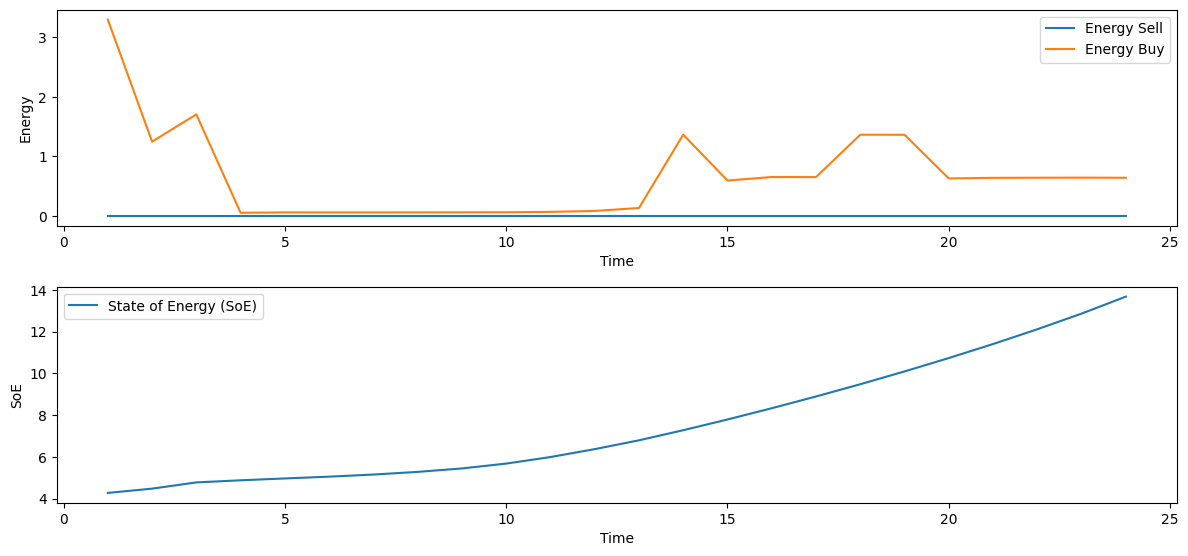

In [7]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt

class BenchmarkOpti:

    def __init__(self, params_dict):
        #
        # Define the parameters given in dictionary
        #
        self.battery_capacities = params_dict['battery_capacities']
        self.battery_charging_power = params_dict['battery_charging_power']
        self.battery_discharging_power = params_dict['battery_discharging_power']
        self.grid_max_power = params_dict['grid_max_power']
        self.inital_soe = params_dict['inital_soe']
        self.feed_in_tariff = params_dict['feed_in_tariff']
        self.time = params_dict['time']
        self.eco_factor = params_dict['eco_factor']

        #
        # Prices in length of time
        #
        self.cost_buy = params_dict['cost_buy']
        self.profit_sell = params_dict['profit_sell']

        #
        # Netload in length of time
        #
        self.netload = params_dict['netload']

        #
        # Emission costs in length of time
        #
        self.emissions = params_dict['emissions']

        #
        # Model definition
        #
        self.model = pyo.AbstractModel()
        self.define_model(self.model)

    #
    # Define the model
    #
    def define_model(self, model):
        model.time = pyo.RangeSet(1, self.time)

        #
        # Decision Variables
        #
        model.energy_sell = pyo.Var(model.time, domain=pyo.NonNegativeReals)
        model.energy_buy = pyo.Var(model.time, domain=pyo.NonNegativeReals)
        model.sell_buy = pyo.Var(model.time, domain=pyo.Binary)

        #
        # Battery action
        #
        model.battery_action = pyo.Var(model.time, domain=pyo.NonNegativeReals)
        model.soe = pyo.Var(model.time, domain=pyo.NonNegativeReals)

        #
        # Time dependent costs
        #
        model.cost_buy = pyo.Param(model.time, initialize=self.cost_buy, domain=pyo.NonNegativeReals)
        model.profit_sell = pyo.Param(model.time, initialize=self.profit_sell, domain=pyo.NonNegativeReals)

        #
        # Time dependent netload
        #
        model.netload = pyo.Param(model.time, initialize=self.netload, domain=pyo.Reals)

        #
        # Time dependent emissions
        #
        model.emissions = pyo.Param(model.time, initialize=self.emissions, domain=pyo.Reals)

        #
        # Activate the constraints
        #
        model.constraint_soe = pyo.Constraint(model.time, rule=self.constraint_rule_soe)
        model.constraint_soe_initial = pyo.Constraint(rule=self.constraint_rule_soe_initial)
        model.constraint_energy_buy_and_sell = pyo.Constraint(model.time, rule=self.constraint_energy_buy_and_sell)
        model.constraint_energy_sell = pyo.Constraint(model.time, rule=self.constraint_energy_sell)
        model.constraint_energy_buy = pyo.Constraint(model.time, rule=self.constraint_energy_buy)
        model.constraint_max_battery_action = pyo.Constraint(model.time, rule=self.constraint_max_battery_action)
        model.constraint_min_battery_action = pyo.Constraint(model.time, rule=self.constraint_min_battery_action)
        model.constraint_soe_balance = pyo.Constraint(model.time, rule=self.constraint_soe_balance)

        #
        # Define objective function
        #
        model.obj = pyo.Objective(rule=self.objective_rule, sense=pyo.maximize)

    #
    # Objective Rule
    #
    def objective_rule(self, model):
        profit = sum(model.energy_sell[t] * model.profit_sell[t] for t in model.time)
        cost = sum(model.energy_buy[t] * model.cost_buy[t] for t in model.time)
        emission_cost = sum(model.energy_buy[t] * model.emissions[t] for t in model.time)
        
        return (1 - self.eco_factor) * (profit - cost) - self.eco_factor * emission_cost
    
    #
    # Constraints
    #
    def constraint_rule_soe(self, model, t):
        return model.soe[t] <= self.battery_capacities
    
    def constraint_rule_soe_initial(self, model):
        return model.soe[1] == self.inital_soe
    
    def constraint_energy_buy_and_sell(self, model, t):
        return 0 == model.energy_buy[t] * model.energy_sell[t]
    
    def constraint_energy_sell(self, model, t):
        return model.energy_sell[t] == (model.netload[t] - model.battery_action[t]) * model.sell_buy[t]

    def constraint_energy_buy(self, model, t):
        return model.energy_buy[t] == (model.netload[t] + model.battery_action[t]) * (1 - model.sell_buy[t])
    
    def constraint_max_battery_action(self, model, t):
        return model.battery_action[t] <= self.battery_charging_power
    
    def constraint_min_battery_action(self, model, t):
        return model.battery_action[t] >= -self.battery_discharging_power

    def constraint_soe_balance(self, model, t):
        if t == 1:
            return pyo.Constraint.Skip
        return model.soe[t] == model.soe[t-1] + model.battery_action[t]

    #
    # Solve the model
    #
    def solve_model(self):
        instance = self.model.create_instance()
        solver = pyo.SolverFactory('ipopt')
        solver.solve(instance, tee=True)
        self.instance = instance

    #
    # Visualize the results
    #
    def visualize_results(self):
        time = list(self.instance.time)
        energy_sell = [self.instance.energy_sell[t].value for t in time]
        energy_buy = [self.instance.energy_buy[t].value for t in time]
        soe = [self.instance.soe[t].value for t in time]

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.plot(time, energy_sell, label='Energy Sell')
        plt.plot(time, energy_buy, label='Energy Buy')
        plt.xlabel('Time')
        plt.ylabel('Energy')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(time, soe, label='State of Energy (SoE)')
        plt.xlabel('Time')
        plt.ylabel('SoE')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Example usage
params_dict = {
    'battery_capacities': 13.5,
    'battery_charging_power': 2.3,
    'battery_discharging_power': -2.3,
    'grid_max_power': 20,
    'inital_soe': 5,
    'feed_in_tariff': 0.1,
    'time': 24,
    'eco_factor': 0.5,
    'cost_buy': {i: 0.2 for i in range(1, 25)},
    'profit_sell': {i: 0.15 for i in range(1, 25)},
    'netload': {i: 1 for i in range(1, 25)},
    'emissions': {i: 0.05 for i in range(1, 25)}
}

benchmark = BenchmarkOpti(params_dict)
benchmark.solve_model()
benchmark.visualize_results()


Ipopt 3.14.14: 
==> Warning: Treating 0 binary and 24 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      262
Number of nonzeros in inequality constraint Jacobian.:       72
Number of nonzeros in Lagrangian Hessian.............:       48

Total number of variables............................:      120
                     variables with only lower bounds:       72
                variables with lower and upper bounds:       24
                     variables with only upper bounds:        0
Tota

Total Profit: -25.299999811292732


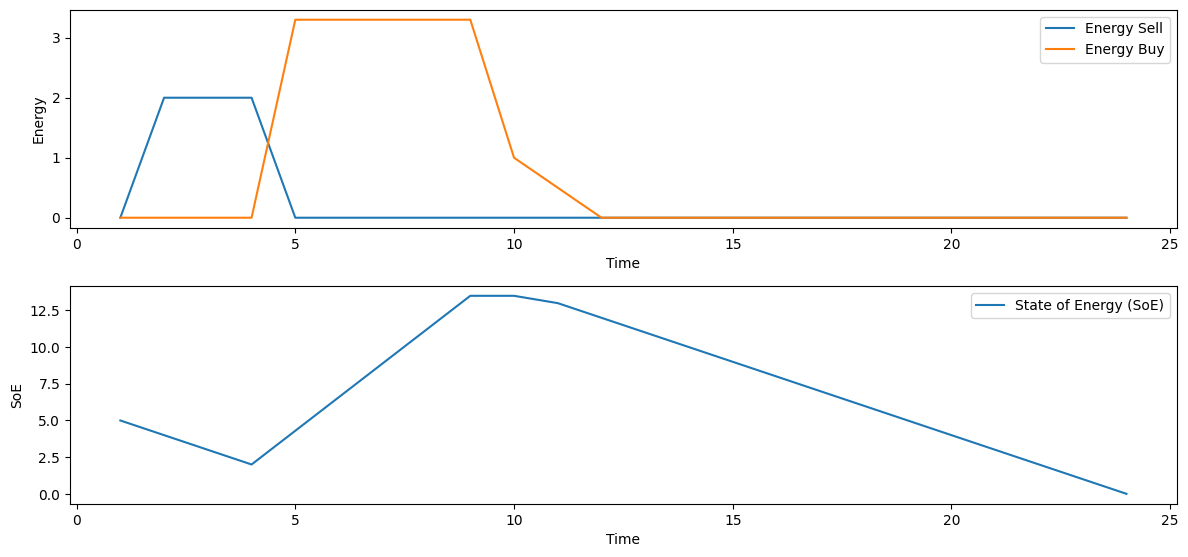

In [15]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt

class BenchmarkOpti:

    def __init__(self, params_dict):
        #
        # Define the parameters given in dictionary
        #
        self.battery_capacities = params_dict['battery_capacities']
        self.battery_charging_power = params_dict['battery_charging_power']
        self.battery_discharging_power = params_dict['battery_discharging_power']
        self.grid_max_power = params_dict['grid_max_power']
        self.inital_soe = params_dict['inital_soe']
        self.feed_in_tariff = params_dict['feed_in_tariff']
        self.time = params_dict['time']
        self.eco_factor = params_dict['eco_factor']

        #
        # Prices in length of time
        #
        self.cost_buy = params_dict['cost_buy']
        self.profit_sell = params_dict['profit_sell']

        #
        # Netload in length of time
        #
        self.netload = params_dict['netload']

        #
        # Emission costs in length of time
        #
        self.emissions = params_dict['emissions']

        #
        # Model definition
        #
        self.model = pyo.AbstractModel()
        self.define_model(self.model)

    #
    # Define the model
    #
    def define_model(self, model):
        model.time = pyo.RangeSet(1, self.time)

        #
        # Decision Variables
        #
        model.energy_sell = pyo.Var(model.time, domain=pyo.NonNegativeReals)
        model.energy_buy = pyo.Var(model.time, domain=pyo.NonNegativeReals)
        model.sell_buy = pyo.Var(model.time, domain=pyo.Binary)

        #
        # Battery action
        #
        model.battery_action = pyo.Var(model.time, domain=pyo.Reals)
        model.soe = pyo.Var(model.time, domain=pyo.NonNegativeReals)

        #
        # Time dependent costs
        #
        model.cost_buy = pyo.Param(model.time, initialize=self.cost_buy, domain=pyo.NonNegativeReals)
        model.profit_sell = pyo.Param(model.time, initialize=self.profit_sell, domain=pyo.NonNegativeReals)

        #
        # Time dependent netload
        #
        model.netload = pyo.Param(model.time, initialize=self.netload, domain=pyo.Reals)

        #
        # Time dependent emissions
        #
        model.emissions = pyo.Param(model.time, initialize=self.emissions, domain=pyo.Reals)

        #
        # Activate the constraints
        #
        model.constraint_soe = pyo.Constraint(model.time, rule=self.constraint_rule_soe)
        model.constraint_soe_initial = pyo.Constraint(rule=self.constraint_rule_soe_initial)
        model.constraint_energy_buy_and_sell = pyo.Constraint(model.time, rule=self.constraint_energy_buy_and_sell)
        model.constraint_energy_sell = pyo.Constraint(model.time, rule=self.constraint_energy_sell)
        model.constraint_energy_buy = pyo.Constraint(model.time, rule=self.constraint_energy_buy)
        model.constraint_max_battery_action = pyo.Constraint(model.time, rule=self.constraint_max_battery_action)
        model.constraint_min_battery_action = pyo.Constraint(model.time, rule=self.constraint_min_battery_action)
        model.constraint_soe_balance = pyo.Constraint(model.time, rule=self.constraint_soe_balance)

        #
        # Define objective function
        #
        model.obj = pyo.Objective(rule=self.objective_rule, sense=pyo.maximize)

    #
    # Objective Rule
    #
    def objective_rule(self, model):
        profit = sum(model.energy_sell[t] * model.profit_sell[t] for t in model.time)
        cost = sum(model.energy_buy[t] * model.cost_buy[t] for t in model.time)
        emission_cost = sum(model.energy_buy[t] * model.emissions[t] for t in model.time)
        
        return (1 - self.eco_factor) * (profit - cost) - self.eco_factor * emission_cost
    
    #
    # Constraints
    #
    def constraint_rule_soe(self, model, t):
        return model.soe[t] <= self.battery_capacities
    
    def constraint_rule_soe_initial(self, model):
        return model.soe[1] == self.inital_soe
    
    def constraint_energy_buy_and_sell(self, model, t):
        return 0 == model.energy_buy[t] * model.energy_sell[t]
    
    def constraint_energy_sell(self, model, t):
        return model.energy_sell[t] == (model.netload[t] - model.battery_action[t]) * model.sell_buy[t]

    def constraint_energy_buy(self, model, t):
        return model.energy_buy[t] == (model.netload[t] + model.battery_action[t]) * (1 - model.sell_buy[t])
    
    def constraint_max_battery_action(self, model, t):
        return model.battery_action[t] <= self.battery_charging_power
    
    def constraint_min_battery_action(self, model, t):
        return model.battery_action[t] >= self.battery_discharging_power

    def constraint_soe_balance(self, model, t):
        if t == 1:
            return pyo.Constraint.Skip
        return model.soe[t] == model.soe[t-1] + model.battery_action[t]

    #
    # Solve the model
    #
    def solve_model(self):
        instance = self.model.create_instance()
        solver = pyo.SolverFactory('ipopt')
        solver.solve(instance, tee=True)
        self.instance = instance

    #
    # Visualize the results
    #
    def visualize_results(self):
        time = list(self.instance.time)
        energy_sell = [self.instance.energy_sell[t].value for t in time]
        energy_buy = [self.instance.energy_buy[t].value for t in time]
        soe = [self.instance.soe[t].value for t in time]

        # Calculate the profit
        profit = sum(energy_sell[t-1] * self.profit_sell[t] for t in time)
        cost = sum(energy_buy[t-1] * self.cost_buy[t] for t in time)
        total_profit = profit - cost

        # Print the profit
        print(f'Total Profit: {total_profit}')

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.plot(time, energy_sell, label='Energy Sell')
        plt.plot(time, energy_buy, label='Energy Buy')
        plt.xlabel('Time')
        plt.ylabel('Energy')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(time, soe, label='State of Energy (SoE)')
        plt.xlabel('Time')
        plt.ylabel('SoE')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Example usage
params_dict = {
    'battery_capacities': 13.5,
    'battery_charging_power': 2.3,
    'battery_discharging_power': -2.3,
    'grid_max_power': 20,
    'inital_soe': 5,
    'feed_in_tariff': 0.1,
    'time': 24,
    'eco_factor': 0.5,
    'cost_buy': {i: 0.2 * i for i in range(1, 25)},
    'profit_sell': {i: 0.15 for i in range(1, 25)},
    'netload': {i: 1 for i in range(1, 25)},
    'emissions': {i: 0.05 for i in range(1, 25)}
}

benchmark = BenchmarkOpti(params_dict)
benchmark.solve_model()
benchmark.visualize_results()
